In [1]:
url="https://archive.ics.uci.edu/dataset/45/heart+disease"

In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
library(janitor)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.4     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

Initial Data

In [3]:
set.seed(1234)
main_data_column_2 <- read_table("cleve.mod", col_names = c('Age', 'Sex', 'Chest Pain Type', 'Resting Blood Pressure',
                                                            'Cholesterol', 'Fasting Blood Sugar <120',
                                                        'Resting ECG Reading', 'Max Heart Rate',
                                                       'Exercise Induced Angina (TRUE or FALSE)',
                                                            'Old Peak', 'Slope', 'Number Of Vessels Coloured', 'thal','Health'), skip = 20)

heart_data<-clean_names(main_data_column_2)
heart_data <- heart_data |>
        mutate(health = as_factor(health))
head(heart_data)



── Column specification ────────────────────────────────────────────────────────
cols(
  Age = col_double(),
  Sex = col_character(),
  `Chest Pain Type` = col_character(),
  `Resting Blood Pressure` = col_double(),
  Cholesterol = col_double(),
  `Fasting Blood Sugar <120` = col_character(),
  `Resting ECG Reading` = col_character(),
  `Max Heart Rate` = col_double(),
  `Exercise Induced Angina (TRUE or FALSE)` = col_character(),
  `Old Peak` = col_double(),
  Slope = col_character(),
  `Number Of Vessels Coloured` = col_character(),
  thal = col_character(),
  Health = col_character()
)

Warning message:
“303 parsing failures.
row col   expected     actual        file
  1  -- 14 columns 15 columns 'cleve.mod'
  2  -- 14 columns 15 columns 'cleve.mod'
  3  -- 14 columns 15 columns 'cleve.mod'
  4  -- 14 columns 15 columns 'cleve.mod'
  5  -- 14 columns 15 columns 'cleve.mod'
... ... .......... .......... ...........
See problems(...) for more details.
”


age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar_120,resting_ecg_reading,max_heart_rate,exercise_induced_angina_true_or_false,old_peak,slope,number_of_vessels_coloured,thal,health
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<fct>
63,male,angina,145,233,true,hyp,150,fal,2.3,down,0.0,fix,buff
67,male,asympt,160,286,fal,hyp,108,true,1.5,flat,3.0,norm,sick
67,male,asympt,120,229,fal,hyp,129,true,2.6,flat,2.0,rev,sick
37,male,notang,130,250,fal,norm,187,fal,3.5,down,0.0,norm,buff
41,fem,abnang,130,204,fal,hyp,172,fal,1.4,up,0.0,norm,buff
56,male,abnang,120,236,fal,norm,178,fal,0.8,up,0.0,norm,buff


Summary Data

In [4]:
num_obs <- heart_data |>
    group_by(health) |>
    summarize(counts = n())
num_obs

predictor_means<-heart_data|>
    select(resting_blood_pressure,cholesterol)|>
    summarize(across(resting_blood_pressure:cholesterol,mean))
predictor_means

health,counts
<fct>,<int>
buff,165
sick,138


resting_blood_pressure,cholesterol
<dbl>,<dbl>
131.6238,246.264


Initial Visualization

sex,resting_blood_pressure,cholesterol,health
<chr>,<dbl>,<dbl>,<fct>
male,130,250,buff
fem,130,204,buff
male,120,236,buff
male,140,192,buff
male,120,263,buff
male,130,266,buff


sex,resting_blood_pressure,cholesterol,health
<chr>,<dbl>,<dbl>,<fct>
male,145,233,buff
fem,120,354,buff
male,140,203,sick
fem,140,294,buff
male,130,206,sick
fem,120,219,buff


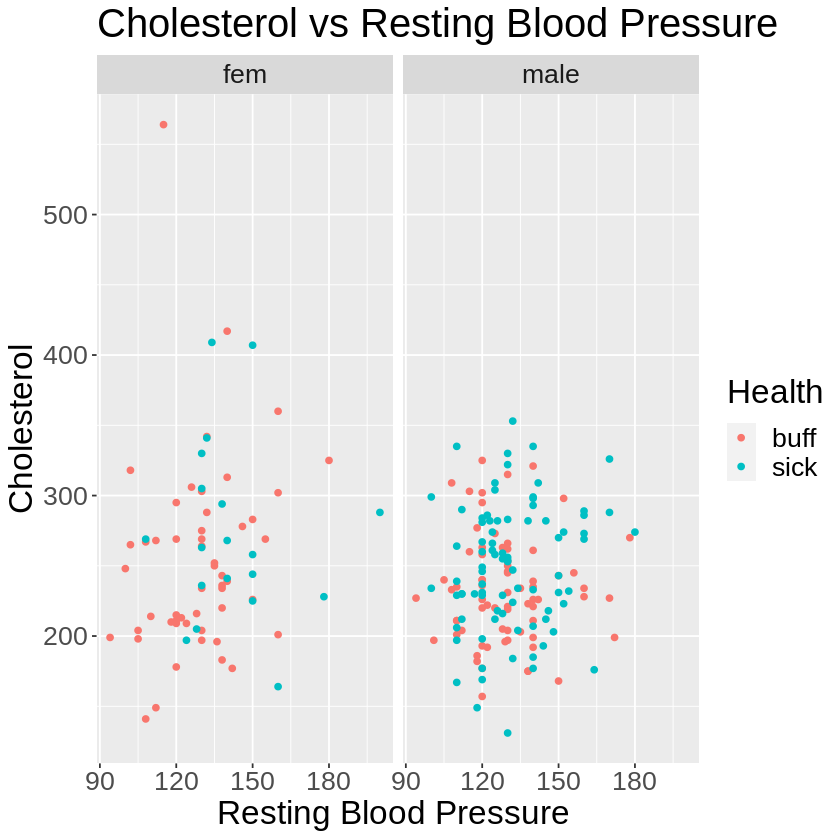

In [5]:

heart_data<-heart_data|>
    select(sex,resting_blood_pressure,cholesterol,health)
heart_split<-initial_split(heart_data,prop=0.75,strata=health)  
heart_train<-training(heart_split)   
heart_test<-testing(heart_split)

head(heart_train)
head(heart_test)

heart_plot<-heart_train|>
    ggplot(aes(x=resting_blood_pressure,y=cholesterol,color=health))+
        geom_point()+
        labs(x="Resting Blood Pressure ",y="Cholesterol", color="Health")+
        theme(text=element_text(size=20))+
        ggtitle("Cholesterol vs Resting Blood Pressure")+
        facet_grid(.~sex)
heart_plot

In [6]:
train_counts <- heart_train |>
    group_by(health) |>
    summarize(n = n()) 

train_counts

health,n
<fct>,<int>
buff,123
sick,103


In [7]:
heart_recipe<-recipe(health~cholesterol+resting_blood_pressure,data=heart_train)

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

k_vals<-tibble(neighbors=seq(2,20))

yVfold<-vfold_cv(heart_train,v=10,strata = health)

knn_results<-workflow()|>
  add_recipe(heart_recipe)|>
  add_model(knn_tune)|>
  tune_grid(resamples=yVfold,grid=k_vals)|>
  collect_metrics() 
head(knn_results)


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.4761364,10,0.02940076,Preprocessor1_Model01
2,roc_auc,binary,0.5035460,10,0.04711020,Preprocessor1_Model01
3,accuracy,binary,0.5602273,10,0.03953633,Preprocessor1_Model02
3,roc_auc,binary,0.5489394,10,0.04777610,Preprocessor1_Model02
4,accuracy,binary,0.5556818,10,0.03700184,Preprocessor1_Model03
4,roc_auc,binary,0.5393502,10,0.04804870,Preprocessor1_Model03


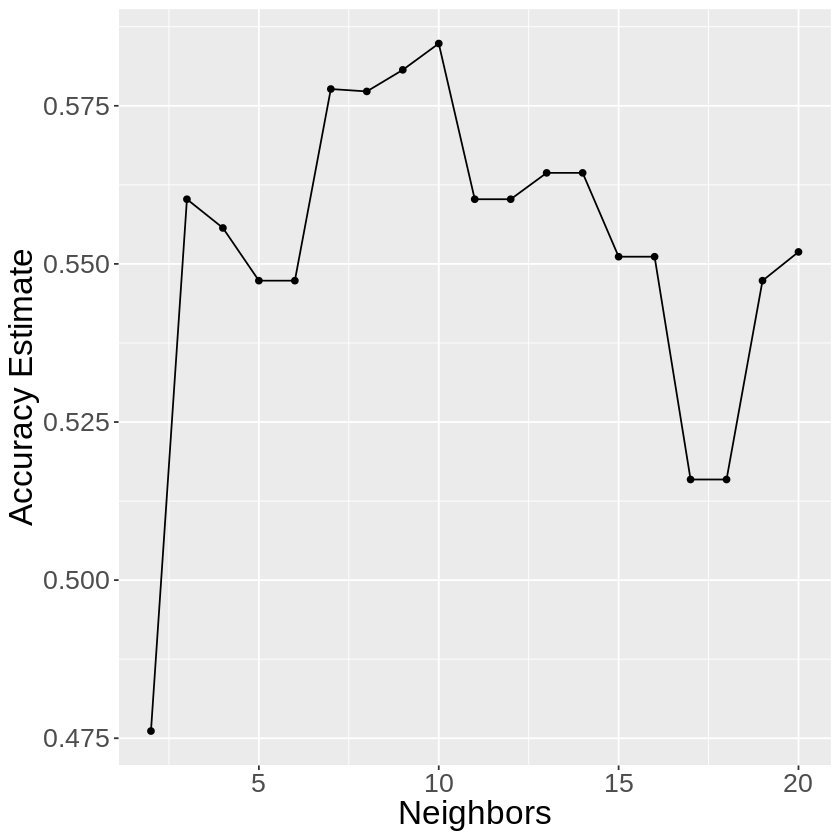

In [8]:
accuracy<-knn_results|>
  filter(.metric=="accuracy")

cross_val_plot <- accuracy|>
    ggplot(aes(x = neighbors, y = mean))+
        geom_point()+
        geom_line()+
        labs(x="Neighbors", y = "Accuracy Estimate")+ 
        theme(text=element_text(size=20))
cross_val_plot

In [10]:
knn_spec<-nearest_neighbor(weight_func="rectangular",neighbors=10)|>
      set_engine("kknn")|>
      set_mode("classification")

heart_fit<-workflow()|>
      add_recipe(heart_recipe)|>
      add_model(knn_spec)|>
      fit(data=heart_train)
heart_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(10,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.460177
Best kernel: rectangular
Best k: 10

In [17]:
heart_test_predictions<-predict(heart_fit,heart_test)|>
    bind_cols(heart_test)
head(heart_test_predictions)

heart_prediction_accuracy<-heart_test_predictions|>
    metrics(truth=health,estimate=.pred_class)|>
    filter(.metric == "accuracy")
head(heart_prediction_accuracy)

conf_matrix <- heart_test_predictions |>
    conf_mat(truth = health, estimate = .pred_class)
conf_matrix

.pred_class,sex,resting_blood_pressure,cholesterol,health
<fct>,<chr>,<dbl>,<dbl>,<fct>
buff,male,145,233,buff
sick,fem,120,354,buff
buff,male,140,203,sick
sick,fem,140,294,buff
buff,male,130,206,sick
buff,fem,120,219,buff


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.5064935


          Truth
Prediction buff sick
      buff   22   18
      sick   20   17

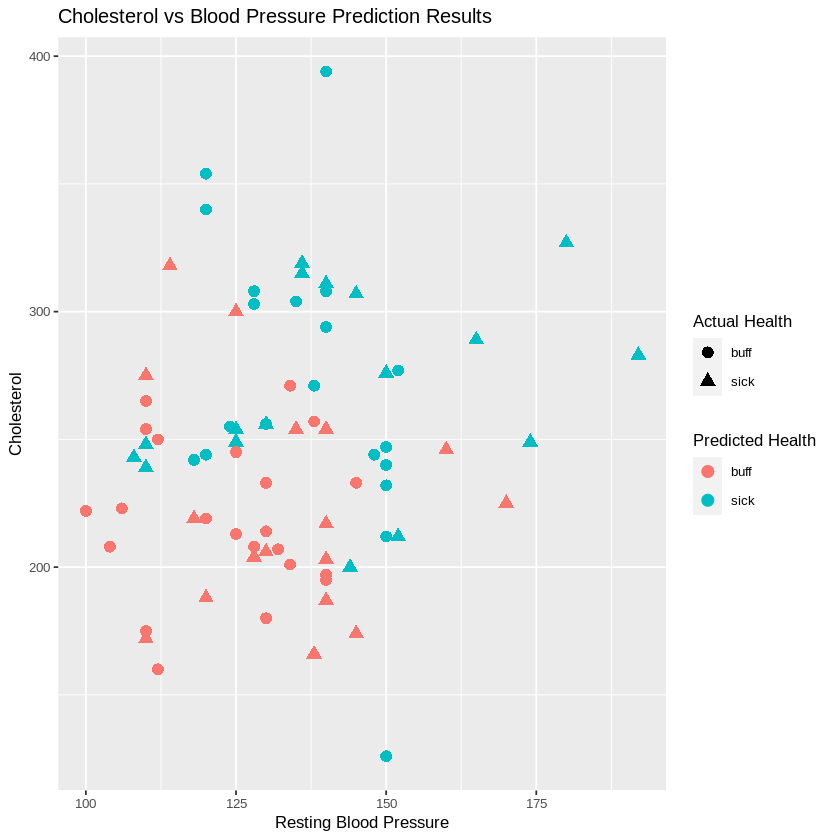

In [24]:
heart_predict_plot <- heart_test_predictions |>
    ggplot(aes(x = resting_blood_pressure, y = cholesterol, color = .pred_class,shape=health)) +
    geom_point(size = 3) +
    labs(x = "Resting Blood Pressure", y = "Cholesterol", color = "Predicted Health",shape="Actual Health") +
    theme(text = element_text(size=10)) +
    ggtitle("Cholesterol vs Blood Pressure Prediction Results")
heart_predict_plot

In [9]:
Plots of inital data and predicted results

sex,resting_blood_pressure,cholesterol,health
<chr>,<dbl>,<dbl>,<fct>
male,130,250,buff
fem,130,204,buff
male,120,236,buff
male,140,192,buff
male,120,263,buff
male,130,266,buff


.pred_class,sex,resting_blood_pressure,cholesterol,health
<fct>,<chr>,<dbl>,<dbl>,<fct>
buff,male,145,233,buff
sick,fem,120,354,buff
buff,male,140,203,sick
sick,fem,140,294,buff
buff,male,130,206,sick
buff,fem,120,219,buff


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.4935065
kap,binary,-0.0141844


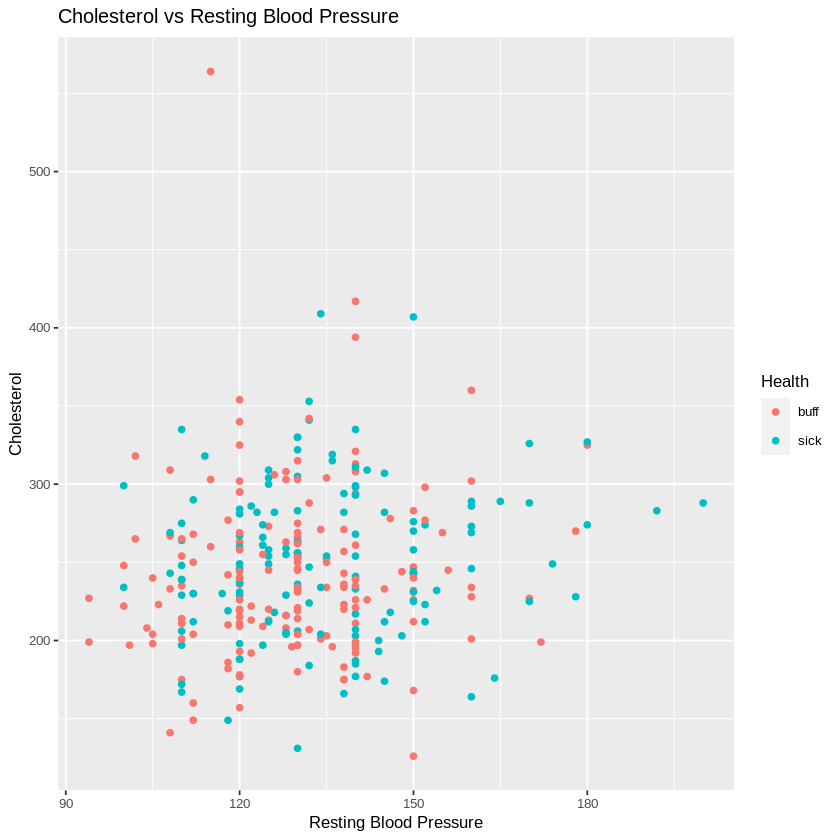

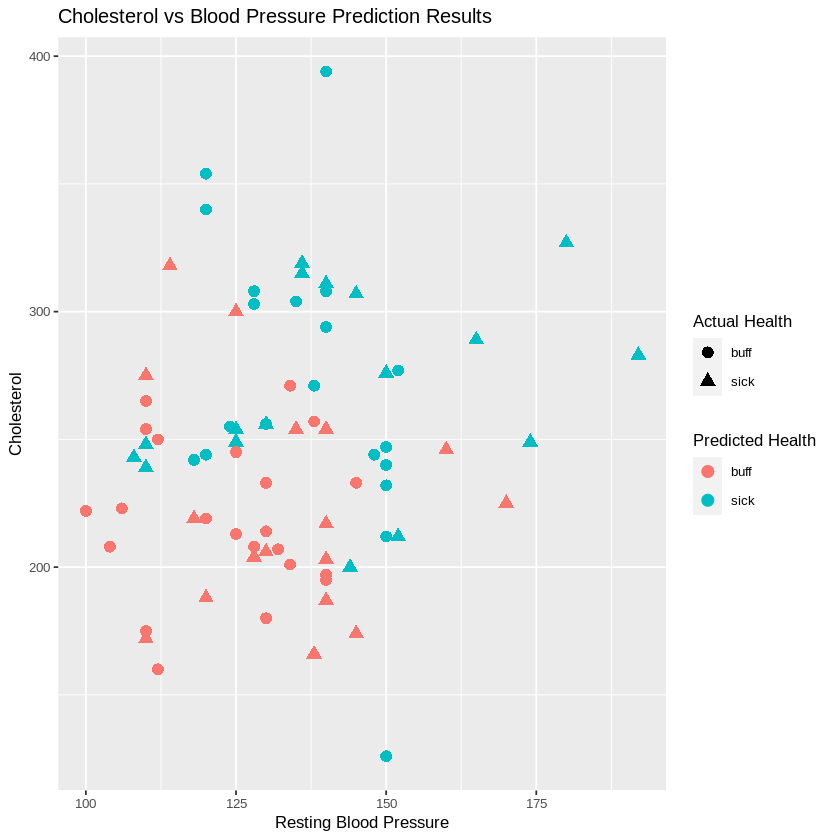

In [28]:
heart_data_plot <- heart_data |>
    ggplot(aes(x = resting_blood_pressure, y = cholesterol, color = health)) +
    geom_point() +
    labs(x = "Resting Blood Pressure", y = "Cholesterol", color = "Health") +
    theme(text = element_text(size=10)) +
    ggtitle("Cholesterol vs Resting Blood Pressure ")
heart_data_plot

heart_predict_plot